# 10-K Distance Analyzer

## WEB SCRAPER

In [1]:
## Import libraries
import nltk
import string
import os
import pandas as pd
import re
from nltk.corpus import stopwords
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from scipy.spatial.distance import cosine
import numpy as np
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as text
from sklearn import decomposition
from bs4 import BeautifulSoup
import urllib2

%matplotlib inline

def visible(element):
    if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
        return False
    elif re.match('<!--.*-->', (element).encode('utf-8')):
        return False
    return True

In [2]:
## Read data from cached file.
import simplejson as json
with open('sample_inputs/sample_500.json', 'r') as fp:
    lda_data_read = json.load(fp)

In [13]:
from gensim.models import Word2Vec

model = Word2Vec.load_word2vec_format("/home/manuel/Downloads/GoogleNews-vectors-negative300.bin", binary=True)

sample = lda_data_read['NATURAL GAS SERVICES GROUP INC']

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored
ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1120, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 301, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 346, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1013, in getframeinfo
    lines, lnum = findsource(frame)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 161, in findsource
    file = getsourcefile(object) or getfile(object)
  File "/usr/lib/python2.7/inspect.py", line 451, in getsourcefile
    if os.path.exists(fi


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

In [10]:
for k, v in sample.iteritems():
    print v[:100]dropz

['unregistered', 'sale', 'equity', 'security', 'use', 'proceed', 'certain', 'statement', 'report', 'include', 'information', 'incorporate', 'reference', 'forwardlooking', 'statement', 'within', 'mean', 'section', 'a', 'security', 'act', 'section', 'e', 'security', 'exchange', 'act', 'private', 'security', 'litigation', 'reform', 'act', 'forwardlooking', 'statement', 'reflect', 'current', 'view', 'future', 'event', 'financial', 'performance', 'base', 'certain', 'assumption', 'include', 'opinion', 'forecast', 'intention', 'plan', 'goal', 'projection', 'guidance', 'expectation', 'belief', 'statement', 'statement', 'historical', 'fact', 'word', 'may', 'could', 'would', 'expect', 'plan', 'belief', 'anticipate', 'intend', 'estimate', 'approximate', 'predict', 'forecast', 'project', 'negative', 'variation', 'word', 'similar', 'expression', 'may', 'identify', 'statement', 'forwardlooking', 'statement', 'statement', 'refer', 'projection', 'future', 'financial', 'performance', 'anticipate', 'gro

### Manually set links here. All other sections are done automatically.

In [22]:
current_name = 'exxon'

htmls = ['https://www.sec.gov/Archives/edgar/data/34088/000119312508041781/d10k.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000119312509040966/d10k.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000119312510042929/d10k.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000119312511047394/d10k.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000119312512078102/d257530d10k.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000003408813000011/xom10k2012.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000003408814000012/xom10k2013.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000003408815000013/xom10k2014.htm',
'https://www.sec.gov/Archives/edgar/data/34088/000003408816000065/xom10k2015.htm'
]

In [23]:
errors = pd.DataFrame(columns=['id', 'year', 'section', 'severity', 'comment', 'url'])
logs = pd.DataFrame(columns=['id', 'year', 'section', 'pre_length', 'length', 'pct_length' ,'url'])

all_docs = {}

for html in htmls:
    print html
    all_sections = {}
    soup = BeautifulSoup(urllib2.urlopen(html).read(), 'html.parser')
    
    ## Extract visible text.
    texts = soup.findAll(text=True)
    visible_texts = filter(visible, texts)
    len_total = len(visible_texts)
    
    ## Extract year and id.
    doc_id = html.split('/')[6]
    pattern_year = re.compile('\d{2}, \d{4}.*')
    year = [line for line in visible_texts if pattern_year.findall(line)][0].split(',')[-1].strip()
    
    ## Log error and skip document if year is wrong.
    if len(year) != 4:
        print 'Year incorrectly defined! Skipping document.'
        errors.loc[len(errors)] = [doc_id, year, 'all', 'error','invalid year format', html]
        continue
    
    ## List all available sections.
    sections = ['1', '1A', '1B', '2', '3', '4', '5', '6', '7', '7A', \
                '8', '9', '9A', '9B', '10', '11', '12', '13', '14', '15']
    
    for i in range(len(sections)-1):
        ## Starting and ending lines for section.
        pattern_start = re.compile("(\s)?Item[(\\xa0)|(\s)]?" + sections[i] + "\.", re.I)
        pattern_end = re.compile("(\s)?Item[(\\xa0)|(\s)]?" + sections[i+1] + "\.", re.I)

        ## Get the start and end headers, and make sure they are exactly 2.
        start = [[s,line] for s,line in enumerate(visible_texts) if pattern_start.match(line)]
        end = [[e,line] for e,line in enumerate(visible_texts) if pattern_end.match(line)]
        
        ## If we extracted more than 1 item for each header, ignore the TOC one.
        if len(start) >1 and len(end) > 1:
            start = [start[1]]
            end = [end[1]]
            
        ## If either of the sections has zero length, report an error.
        if len(start) == 0 or len(end) == 0:
            print 'Section %s incorrectly defined! Skipping...' %sections[i]
            errors.loc[len(errors)] = [doc_id, year, 'all', 'error', 'headers not defined', html]
            continue
        
        ## Extract section counter, and remove small text.
        content = visible_texts[start[0][0]:end[0][0]]
        len_pre = len(content)
        content_valid = [item for item in content if len(item) > 50]
        
        ## Checks for section length.
        len_content = len(content_valid)
        len_ratio = len_content / float(len_total)

        if len_ratio == 0:
            errors.loc[len(errors)] = [doc_id, year, sections[i], 'warning','length zero', html]
            print 'Section %s on year %s has zero length!!!' %(sections[i], year)
            
        elif len_ratio > 0.8:
            errors.loc[len(errors)] = [doc_id, year, sections[i], 'warning','length 80% of document', html]
            print 'Section %s on year %s is more than 80% of the document.'
        ## Add section to dictionary and log.
        logs.loc[len(logs)] = [doc_id, year, sections[i], len_pre, len_content, len_ratio, html]
        all_sections[sections[i]] = content_valid
    all_docs[str(doc_id + '_' + year)] = all_sections

https://www.sec.gov/Archives/edgar/data/34088/000119312508041781/d10k.htm
Section 1B on year 2007 has zero length!!!
Section 8 on year 2007 has zero length!!!
Section 9A on year 2007 has zero length!!!
Section 9B on year 2007 has zero length!!!
https://www.sec.gov/Archives/edgar/data/34088/000119312509040966/d10k.htm
Section 1B on year 2008 has zero length!!!
Section 8 on year 2008 has zero length!!!
Section 9A on year 2008 has zero length!!!
Section 9B on year 2008 has zero length!!!
https://www.sec.gov/Archives/edgar/data/34088/000119312510042929/d10k.htm
Section 1B on year 2009 has zero length!!!
Section 8 on year 2009 has zero length!!!
Section 9A on year 2009 has zero length!!!
Section 9B on year 2009 has zero length!!!
https://www.sec.gov/Archives/edgar/data/34088/000119312511047394/d10k.htm
Section 1B on year 2010 has zero length!!!
Section 3 incorrectly defined! Skipping...
Section 4 incorrectly defined! Skipping...
Section 8 on year 2010 has zero length!!!
Section 9A on year 2

# TF-IDF

In [24]:
token_dict = {}
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = re.sub(r"\W", " ", text)
    text = re.sub(r'\d+', '', text)
    tokens = nltk.word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(filtered_words, stemmer)
    return stems

def risk_extractor(documents):
    risks = {}
    for key in documents.keys():
        if('1A' not in documents[key]):
            risks[key] = ''
            continue
        text = '\n'.join(documents[key]['1A'])
        text = str(text.encode("utf-8")).lower()
        text = text.translate(None, string.punctuation)
        risks[key] = text
    return risks
    
def risk_documenter(documents, doc_name):
    risks = []
    for key in documents.keys():
        if('1A' not in documents[key]):
            text = ''
        else:
            text = ''.join(documents[key]['1A'])
            text = str(text.encode("utf-8")).lower()
            text = text.translate(None, string.punctuation)
        risk_file = open(doc_name + '_risk_' + key + '.txt', "w")
        risk_file.write(text)
        risk_file.close()
        
## Extract risk data and print to file (for legacy purposes).
token_dict = risk_extractor(all_docs)
risk_documenter(all_docs, current_name)
token_dict = collections.OrderedDict(sorted(token_dict.items()))

#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())

In [25]:
data = tfs.todense()
i = 0
j = 1
change = []
while j <= len(token_dict.keys()) - 1:
    cos_sim = cosine(data[i,:], data[j,:])
    if np.isnan(cos_sim):
        cos_sim = 0
    change.append(cos_sim)
    print cos_sim
    j += 1
    i += 1    

0.224813448579
0.523882325694
0.00556969947816
0.0108984161484
0.0113082300561
0.009283530859
0.00191926515842
0.0284013336728


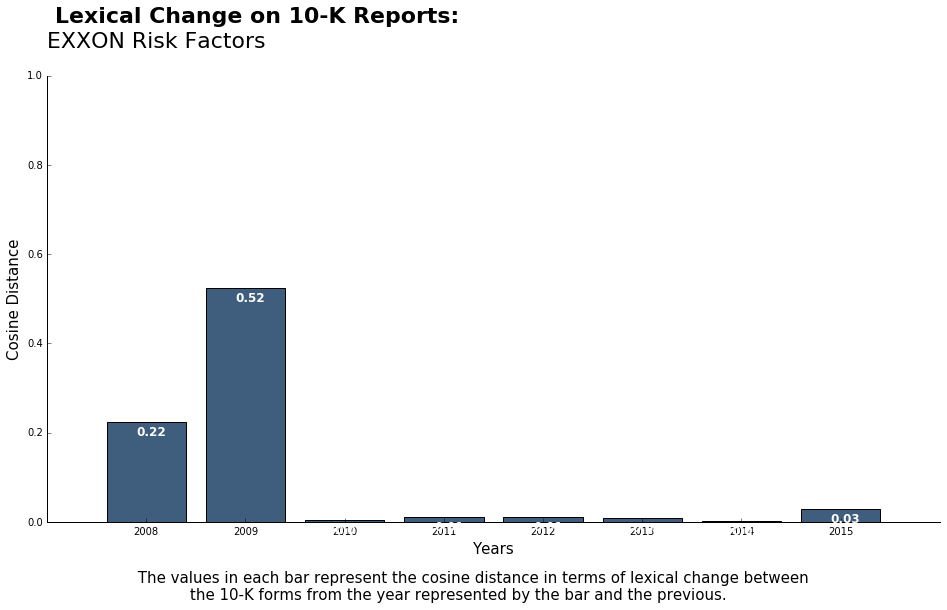

In [26]:
years = ['2008','2009','2010','2011','2012','2013','2014','2015']
x_pos = np.arange(len(years))

fig = plt.figure(figsize=(16, 8))  

ax = plt.subplot(111)
plt.bar(x_pos, change, align = 'center', color="#3F5D7D")
plt.xticks(x_pos, years)
plt.ylabel("Cosine Distance", size = 15)
plt.xlabel("Years", size = 15)
plt.suptitle("Lexical Change on 10-K Reports:", x = 0.307, y = 1.02, fontsize = 22, fontweight = 'bold')
plt.title("\n" + current_name.upper() + " Risk Factors\n", fontsize = 22, loc = 'left')
plt.ylim([0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
for i, v in enumerate(change):
    ax.text(i - 0.1, v - 0.03, str(round(v,2)), color='white', fontweight='bold', size = 12)
    #print(i,v)
fig.text(0.2,-0.01,''' The values in each bar represent the cosine distance in terms of lexical change between
            the 10-K forms from the year represented by the bar and the previous.''', fontsize = 15);

In [27]:
feature_names = tfidf.get_feature_names()
#np.sort(data[0,:], )
top0_ind = np.array(np.ravel((-data[0,:]).argsort())[:10], dtype = int)
top1_ind = np.array(np.ravel((-data[1,:]).argsort())[:10], dtype = int)
top2_ind = np.array(np.ravel((-data[2,:]).argsort())[:10], dtype = int)
top3_ind = np.array(np.ravel((-data[3,:]).argsort())[:10], dtype = int)
print("top words 2007")
print([feature_names[i] for i in list(top0_ind)], "\n")
print("top words 2008")
print([feature_names[i] for i in list(top1_ind)], "\n")
print("top words 2009")
print([feature_names[i] for i in list(top2_ind)], "\n")
print("top words 2010")
print([feature_names[i] for i in list(top3_ind)], "\n")

top5_ind = np.array(np.ravel((-data[5,:]).argsort())[:10], dtype = int)
top6_ind = np.array(np.ravel((-data[6,:]).argsort())[:10], dtype = int)
print([feature_names[i] for i in list(top5_ind)], "\n")
print([feature_names[i] for i in list(top6_ind)], "\n")

top words 2007
([u'corpor', u'includ', u'oper', u'advanc', u'energi', u'product', u'busi', u'factor', u'project', u'affect'], '\n')
top words 2008
([u'corpor', u'includ', u'deriv', u'oper', u'price', u'crude', u'product', u'market', u'chang', u'sale'], '\n')
top words 2009
([u'ga', u'busi', u'oil', u'affect', u'oper', u'manag', u'project', u'result', u'exxonmobil', u'petrochem'], '\n')
top words 2010
([u'busi', u'ga', u'oper', u'oil', u'manag', u'project', u'affect', u'chang', u'result', u'exxonmobil'], '\n')
([u'busi', u'project', u'oper', u'ga', u'manag', u'affect', u'risk', u'exxonmobil', u'oil', u'includ'], '\n')
([u'busi', u'oper', u'ga', u'project', u'manag', u'affect', u'risk', u'exxonmobil', u'includ', u'oil'], '\n')


# NON NEGATIVE MATRIX FACTORIZATION

In [28]:
#vectorizer = text.CountVectorizer(tokenizer=tokenize, stop_words='english')
#dtm = vectorizer.fit_transform(token_dict.values()).toarray()
num_topics = 4
num_top_words = 20
clf = decomposition.NMF(n_components=num_topics, random_state=1)

In [29]:
doctopic = clf.fit_transform(tfs)
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [30]:
H = clf.components_
# topic_words = []

# for topic_index in range( H.shape[0] ):
#     top_indices = np.argsort( H[topic_index,:] )[::-1][0:10]
#     term_ranking = [terms[i] for i in top_indices]
#     print(topic_index, term_ranking )
for topic_index in range(H.shape[0]):
    top_indices = np.array(np.ravel((-H[topic_index,:]).argsort())[:10], dtype = int)
    top_terms = [feature_names[i] for i in top_indices]
    print("Topic %s: %s" %(topic_index, ",  ".join(top_terms)))

Topic 0: busi,  ga,  oper,  oil,  manag,  project,  affect,  exxonmobil,  result,  chang
Topic 1: corpor,  includ,  oper,  advanc,  energi,  product,  factor,  busi,  cost,  market
Topic 2: corpor,  deriv,  includ,  price,  oper,  crude,  product,  chang,  market,  sale
Topic 3: busi,  oper,  govern,  risk,  includ,  project,  exxonmobil,  ga,  advers,  chang


In [134]:
## Here we replace NaN with zero. This is probably not ok.
doctopic[np.isnan(doctopic)]=0

i = 0
j = 1
change_topic = []
while j <= len(token_dict.keys()) - 1:
    cos_sim2 = cosine(doctopic[i,:], doctopic[j,:])
    if np.isnan(cos_sim2):
        cos_sim2 = 0
    change_topic.append(cos_sim2)
    print(cos_sim2)
    j += 1
    i += 1    

0.983989327306
1.0
2.26744742464e-05
0.0632088231935
0.0172035797006
0.00168406292535
0.000657734833546
0.0485124788407


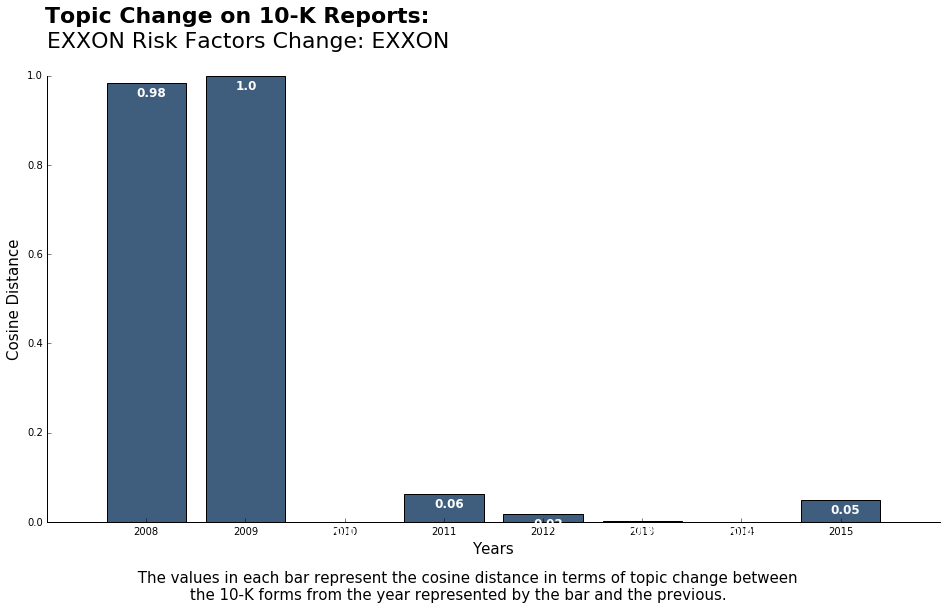

In [135]:
years = ['2008','2009','2010','2011','2012','2013','2014','2015']
x_pos = np.arange(len(years))

fig = plt.figure(figsize=(16, 8))  

ax = plt.subplot(111)
plt.bar(x_pos, change_topic, align = 'center', color="#3F5D7D")
plt.xticks(x_pos, years)
plt.ylabel("Cosine Distance", size = 15)
plt.xlabel("Years", size = 15)
plt.suptitle("Topic Change on 10-K Reports:", x = 0.29, y = 1.02, fontsize = 22, fontweight = 'bold')
plt.title("\n" + current_name.upper() + " Risk Factors Change: EXXON \n", fontsize = 22, loc = 'left')
plt.ylim([0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

for i, v in enumerate(change_topic):
    ax.text(i - 0.1, v - 0.03, str(round(v,2)), color='white', fontweight='bold', size = 12)
    #print(i,v)
fig.text(0.2,-0.01,''' The values in each bar represent the cosine distance in terms of topic change between
            the 10-K forms from the year represented by the bar and the previous.''', fontsize = 15);

## Doc2Vec

In [91]:
from collections import namedtuple
from gensim.models.doc2vec import TaggedDocument

alldocs = []

for key in token_dict.keys():
    tokens = token_dict[key].split()
    alldocs.append(TaggedDocument(words=tokens, tags=key))
#all_tokens

In [125]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec

simple_model = Doc2Vec(alldocs, size=100, window=8, min_count=5, workers=4)

In [130]:
## Here we replace NaN with zero. This is probably not ok.
doctopic[np.isnan(doctopic)]=0

i = 0
j = 1
change_topic = []
while j <= len(alldocs)-1:
    docvec = abs(simple_model.docvecs.similarity(i,j))
    if np.isnan(docvec):
        docvec = 0
    change_topic.append(docvec)
    print(docvec)
    j += 1
    i += 1    

0.811249574567
0.101618695065
0.414567641287
0.48194823777
0.804749828983
0.714253325718
0.919466196598
0.883225872474


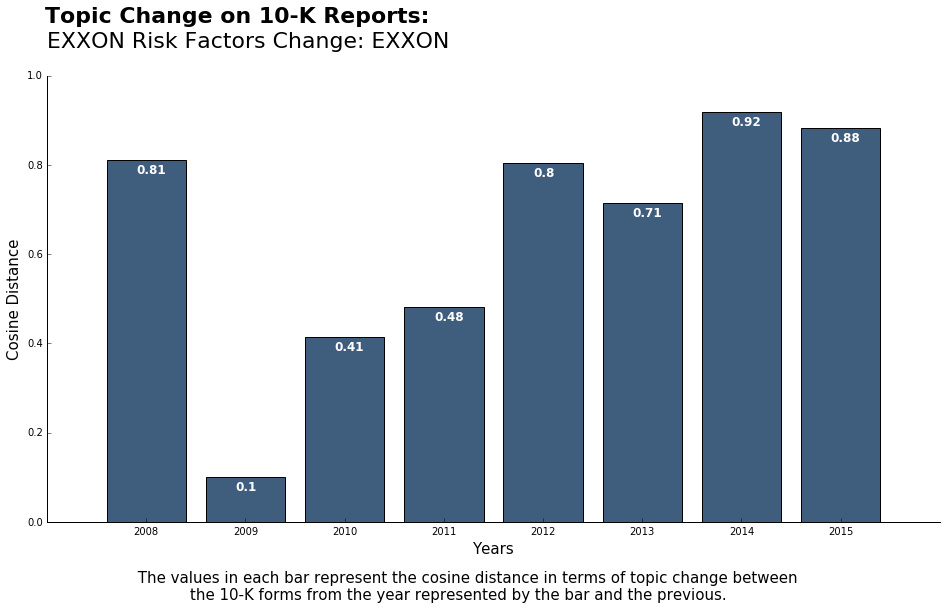

In [132]:
years = ['2008','2009','2010','2011','2012','2013','2014','2015']
x_pos = np.arange(len(years))

fig = plt.figure(figsize=(16, 8))  

ax = plt.subplot(111)
plt.bar(x_pos, change_topic, align = 'center', color="#3F5D7D")
plt.xticks(x_pos, years)
plt.ylabel("Cosine Distance", size = 15)
plt.xlabel("Years", size = 15)
plt.suptitle("Topic Change on 10-K Reports:", x = 0.29, y = 1.02, fontsize = 22, fontweight = 'bold')
plt.title("\n" + current_name.upper() + " Risk Factors Change: EXXON \n", fontsize = 22, loc = 'left')
plt.ylim([0,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

for i, v in enumerate(change_topic):
    ax.text(i - 0.1, v - 0.03, str(round(v,2)), color='white', fontweight='bold', size = 12)
    #print(i,v)
fig.text(0.2,-0.01,''' The values in each bar represent the cosine distance in terms of topic change between
            the 10-K forms from the year represented by the bar and the previous.''', fontsize = 15);

---

---

---

---

## Scraper Test Zone
To test the extraction of individual sections on specific documents.

In [72]:
htmls = 'https://www.sec.gov/Archives/edgar/data/1065280/000106528013000008/nflx1231201210kdoc.htm'
soup = BeautifulSoup(urllib2.urlopen(html).read(), 'html.parser')

texts = soup.findAll(text=True)
visible_texts = filter(visible, texts)

## Check if year is extracted.
year = [line for line in visible_texts if pattern_year.findall(line)][0].split(',')[-1].strip()
print year

sections = ['1A', '1B']
i=0

## Starting and ending patterns.
pattern_start = re.compile("(\s)?Item[(\\xa0)|(\s)]?" + sections[i] + "\.")
pattern_end = re.compile("(\s)?Item[(\\xa0)|(\s)]?" + sections[i+1] + "\.")

## Try to get headers.
start = [[s,line] for s,line in enumerate(visible_texts) if pattern_start.match(line)]
end = [[e,line] for e,line in enumerate(visible_texts) if pattern_end.match(line)]

print start
print end

2015
[[111, u'Item\xa01A.'], [235, u'Item 1A.']]
[[114, u'Item\xa01B.'], [415, u'Item 1B.']]


In [211]:
pattern_start = re.compile("(\s)?Item[(\\xa0)|(\s)]?" + '1A' + "\.", re.I)
print pattern_start.match('ITEM 1A.')

In [14]:
visible_texts

[u'\n',
 u'10-K\n',
 u'1\n',
 u'nflx201510k.htm\n',
 u'10-K\n',
 u'\n',
 u'html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"',
 u'\n',
 u'\n',
 u'\n',
 u'\n',
 u'\xa0',
 u'UNITED\xa0STATES\xa0SECURITIES\xa0AND\xa0EXCHANGE\xa0COMMISSION',
 u'Washington, D.C. 20549',
 u'\xa0_____________________________________________________________________',
 u'FORM 10-K',
 u'\xa0_____________________________________________________________________',
 u'(Mark One)',
 u'x',
 u'ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES\xa0EXCHANGE ACT OF 1934',
 u'For the fiscal year ended December\xa031, 2015',
 u'OR',
 u'o',
 u'TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934',
 u'For the transition period from \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 to \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0',
 u'Commission File Number: 001-35727',
 u'_______________________________________________________________